# Random Forest Modell für Weinqualitäts-Vorhersage

Dieses Notebook trainiert ein Random Forest Modell zur Vorhersage der Weinqualität basierend auf den chemischen Eigenschaften des Weins.


In [22]:
# ============================================================================
# KONFIGURATION: Alle Modell- und Experiment-Parameter
# ============================================================================

# Daten-Parameter
DATA_PATH = 'Base-Data/winequality-red.csv'
TEST_SIZE = 0.2
RANDOM_STATE = 42
STRATIFY = True  # Stratifizierte Aufteilung für balancierte Klassenverteilung

# Random Forest Modell-Parameter
N_ESTIMATORS = 500  # Anzahl der Bäume im Wald
MAX_DEPTH = None  # Maximale Tiefe der Bäume (None = unbegrenzt)
MIN_SAMPLES_SPLIT = 2  # Minimale Anzahl Samples zum Splitten eines Knotens
MIN_SAMPLES_LEAF = 1  # Minimale Anzahl Samples in einem Blatt
MAX_FEATURES = 'sqrt'  # Anzahl Features pro Split: 'sqrt', 'log2', None oder int
Bootstrap = True  # Bootstrap-Stichproben (mit Zurücklegen)
MAX_SAMPLES = None  # Anzahl Samples pro Bootstrap (None = alle)
N_JOBS = -1  # Anzahl paralleler Jobs (-1 = alle CPUs)
VERBOSE = 1  # Ausgabe während Training

# GridSearchCV Parameter
USE_GRIDSEARCH = True  # GridSearchCV für Hyperparameter-Tuning verwenden
CV_FOLDS = 5  # Anzahl Folds für Cross-Validation
GRIDSEARCH_SCORING = 'r2'  # Scoring-Metrik für GridSearchCV
GRIDSEARCH_VERBOSE = 1  # Verbosity für GridSearchCV

# Parameter Grid für GridSearchCV
PARAM_GRID = {
    'max_depth': [8, 10, 12, 15, 20],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 5, 8],
    'max_features': ['sqrt', 'log2', 0.5],
    'max_samples': [0.7, 0.8, None]
}

# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import warnings

# Konfiguration
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("=" * 70)
print("KONFIGURATION GELADEN")
print("=" * 70)
print(f"Anzahl Bäume (N_ESTIMATORS): {N_ESTIMATORS}")
print(f"Max Features pro Split: {MAX_FEATURES}")
print(f"Bootstrap: {Bootstrap}")
print(f"Test Size: {TEST_SIZE}")
print(f"Random State: {RANDOM_STATE}")
print(f"\nGridSearchCV: {'AKTIVIERT' if USE_GRIDSEARCH else 'DEAKTIVIERT'}")
if USE_GRIDSEARCH:
    print(f"CV Folds: {CV_FOLDS}")
    print(f"Scoring: {GRIDSEARCH_SCORING}")
    print(f"Parameter-Kombinationen: {len(PARAM_GRID['max_depth']) * len(PARAM_GRID['min_samples_split']) * len(PARAM_GRID['min_samples_leaf']) * len(PARAM_GRID['max_features']) * len(PARAM_GRID['max_samples'])}")
print("=" * 70)


KONFIGURATION GELADEN
Anzahl Bäume (N_ESTIMATORS): 500
Max Features pro Split: sqrt
Bootstrap: True
Test Size: 0.2
Random State: 42

GridSearchCV: AKTIVIERT
CV Folds: 5
Scoring: r2
Parameter-Kombinationen: 540


## 1. Daten laden und vorbereiten


In [23]:
# Daten einlesen
df = pd.read_csv(DATA_PATH)

print(f"Datensatz Form: {df.shape}")
print(f"\nErste 5 Zeilen:")
df.head()


Datensatz Form: (1599, 12)

Erste 5 Zeilen:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [24]:
# Daten bereinigen: Duplikate entfernen
df_clean = df.copy()
initial_shape = df_clean.shape[0]
df_clean = df_clean.drop_duplicates()
final_shape = df_clean.shape[0]
removed = initial_shape - final_shape

print(f"Ursprüngliche Anzahl Zeilen: {initial_shape}")
print(f"Nach Entfernen von Duplikaten: {final_shape}")
print(f"Entfernte Zeilen: {removed}")

# Prüfung auf fehlende Werte
missing_values = df_clean.isnull().sum().sum()
print(f"\nFehlende Werte: {missing_values}")
if missing_values == 0:
    print("✓ Keine fehlenden Werte gefunden!")


Ursprüngliche Anzahl Zeilen: 1599
Nach Entfernen von Duplikaten: 1359
Entfernte Zeilen: 240

Fehlende Werte: 0
✓ Keine fehlenden Werte gefunden!


In [25]:
# Feature und Target Definition
X = df_clean.drop('quality', axis=1)  # Features
y = df_clean['quality']  # Target

print(f"Feature Matrix Shape: {X.shape}")
print(f"Target Vector Shape: {y.shape}")
print(f"\nFeature Namen:")
print(X.columns.tolist())
print(f"\nTarget Statistik:")
print(y.describe())
print(f"\nTarget Verteilung:")
print(y.value_counts().sort_index())


Feature Matrix Shape: (1359, 11)
Target Vector Shape: (1359,)

Feature Namen:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

Target Statistik:
count    1359.000000
mean        5.623252
std         0.823578
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

Target Verteilung:
quality
3     10
4     53
5    577
6    535
7    167
8     17
Name: count, dtype: int64


In [26]:
# Train-Test Split
if STRATIFY:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

print("=== TRAIN-TEST SPLIT ===\n")
print(f"Train Set - Features: {X_train.shape}, Target: {y_train.shape}")
print(f"Test Set - Features: {X_test.shape}, Target: {y_test.shape}")
print(f"\nTrain Set Quality Verteilung:")
print(y_train.value_counts().sort_index())
print(f"\nTest Set Quality Verteilung:")
print(y_test.value_counts().sort_index())


=== TRAIN-TEST SPLIT ===

Train Set - Features: (1087, 11), Target: (1087,)
Test Set - Features: (272, 11), Target: (272,)

Train Set Quality Verteilung:
quality
3      8
4     42
5    461
6    428
7    134
8     14
Name: count, dtype: int64

Test Set Quality Verteilung:
quality
3      2
4     11
5    116
6    107
7     33
8      3
Name: count, dtype: int64


## 2. Random Forest: Vorgehen und Konzept

### Bootstrap-Stichproben (Bagging):
- **Zufällig mit Zurücklegen**: Jeder Baum wird auf einer Bootstrap-Stichprobe trainiert
- **Jeder Baum sieht leicht andere Stichprobe**: Durch zufälliges Sampling mit Zurücklegen entstehen unterschiedliche Trainingssets
- **N Bäume trainieren**: In unserem Fall trainieren wir **500 Bäume** (N_ESTIMATORS)

### Feature-Subsampling:
- **Jeder Baum nutzt Teilmenge der Features**: Bei jedem Split werden nur zufällig ausgewählte Features betrachtet (MAX_FEATURES = 'sqrt')
- **Jeder Baum lernt unterschiedliche Muster**: Durch verschiedene Feature-Kombinationen entstehen diverse Bäume

### Ensemble-Aggregation:
- **Alle 500 Bäume machen Vorhersage**: Jeder Baum gibt eine Vorhersage ab
- **Endergebnis = Durchschnitt aller Vorhersagen**: Die finalen Vorhersagen werden gemittelt
- **→ reduziert Varianz, robust gegen Overfitting**: Durch Aggregation wird die Varianz reduziert und das Modell generalisiert besser

**Hinweis**: Random Forest verwendet **Bagging** (Bootstrap Aggregating), nicht Boosting. Bei Bagging werden die Bäume parallel trainiert, während Boosting sequenziell arbeitet und jeden neuen Baum auf die Fehler der vorherigen fokussiert.


## 3. Random Forest Modell trainieren


In [27]:
# Random Forest Modell initialisieren
rf_model = RandomForestRegressor(
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    min_samples_split=MIN_SAMPLES_SPLIT,
    min_samples_leaf=MIN_SAMPLES_LEAF,
    max_features=MAX_FEATURES,
    bootstrap=Bootstrap,
    max_samples=MAX_SAMPLES,
    n_jobs=N_JOBS,
    random_state=RANDOM_STATE,
    verbose=VERBOSE
)

print("Random Forest Modell initialisiert:")
print(f"  - Anzahl Bäume: {N_ESTIMATORS}")
print(f"  - Max Features: {MAX_FEATURES}")
print(f"  - Bootstrap: {Bootstrap}")
print(f"  - Max Depth: {MAX_DEPTH}")
print(f"  - Random State: {RANDOM_STATE}")
print("\nStarte Training...")
print("=" * 70)


Random Forest Modell initialisiert:
  - Anzahl Bäume: 500
  - Max Features: sqrt
  - Bootstrap: True
  - Max Depth: None
  - Random State: 42

Starte Training...


### GridSearchCV: Systematisches Hyperparameter-Tuning

**Was ist GridSearchCV?**
- GridSearchCV testet automatisch alle Kombinationen von Hyperparametern
- Verwendet Cross-Validation (CV) um die beste Kombination zu finden
- Reduziert Overfitting durch optimale Parameterwahl

**Wichtige Hyperparameter erklärt:**

- **max_depth**: Maximale Tiefe der Entscheidungsbäume
  - Niedrigere Werte → weniger komplexe Bäume → weniger Overfitting
  - Höhere Werte → komplexere Bäume → bessere Train-Performance, aber Risiko von Overfitting

- **min_samples_split**: Minimale Anzahl Samples zum Splitten eines Knotens
  - Höhere Werte → weniger Splits → einfachere Bäume → weniger Overfitting
  - Verhindert, dass Bäume zu tief werden

- **min_samples_leaf**: Minimale Anzahl Samples in einem Blatt (Endknoten)
  - Höhere Werte → größere Blätter → stabilere Vorhersagen → weniger Overfitting
  - Ein Blatt ist ein Endknoten im Baum, der keine weiteren Splits macht

- **max_features**: Anzahl Features pro Split
  - 'sqrt': Wurzel aus Gesamtanzahl Features
  - 'log2': Logarithmus zur Basis 2
  - 0.5: 50% der Features
  - Weniger Features → mehr Diversität zwischen Bäumen

- **max_samples**: Anteil der Samples pro Baum (Bootstrap-Sampling)
  - 0.7 = 70% der Trainingsdaten pro Baum
  - None = 100% (alle Daten)
  - Weniger Samples → mehr Diversität → bessere Generalisierung


## 3.1 Training-Progress: Fehler über Zeit während des Trainings


In [28]:
# ============================================================================
# TRAINING PROGRESS VISUALISIERUNG
# Berechnet Fehler über verschiedene Anzahl Bäume während des Trainings
# ============================================================================

# Inkrementelle Vorhersagen über Anzahl Bäume
n_trees_range = [1, 10, 50, 100, 200, 300, 400, N_ESTIMATORS]
train_errors_progress = []
test_errors_progress = []
train_r2_progress = []
test_r2_progress = []
oob_errors_progress = []
training_times_progress = []

print("Berechne Training-Progress über Anzahl Bäume...")
print("Dies kann einige Minuten dauern...\n")

for i, n_trees in enumerate(n_trees_range):
    print(f"Training mit {n_trees} Bäumen...", end=" ")
    
    # Temporäres Modell mit weniger Bäumen
    temp_rf = RandomForestRegressor(
        n_estimators=n_trees,
        max_depth=MAX_DEPTH,
        min_samples_split=MIN_SAMPLES_SPLIT,
        min_samples_leaf=MIN_SAMPLES_LEAF,
        max_features=MAX_FEATURES,
        bootstrap=Bootstrap,
        max_samples=MAX_SAMPLES,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        oob_score=True,
        verbose=0
    )

    start_temp = time.time()
    temp_rf.fit(X_train, y_train)
    temp_time = time.time() - start_temp
    training_times_progress.append(temp_time)

    # Vorhersagen und Fehler berechnen
    y_train_temp_pred = temp_rf.predict(X_train)
    y_test_temp_pred = temp_rf.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_temp_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_temp_pred))
    train_r2 = r2_score(y_train, y_train_temp_pred)
    test_r2 = r2_score(y_test, y_test_temp_pred)

    train_errors_progress.append(train_rmse)
    test_errors_progress.append(test_rmse)
    train_r2_progress.append(train_r2)
    test_r2_progress.append(test_r2)

    # OOB Score konvertieren zu RMSE für Vergleichbarkeit
    if hasattr(temp_rf, 'oob_prediction_'):
        oob_rmse = np.sqrt(mean_squared_error(y_train, temp_rf.oob_prediction_))
        oob_errors_progress.append(oob_rmse)
    else:
        oob_errors_progress.append(None)

    print(f"✓ (Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Zeit: {temp_time:.2f}s)")

print("\nTraining-Progress berechnet!")


Berechne Training-Progress über Anzahl Bäume...
Dies kann einige Minuten dauern...

Training mit 1 Bäumen... ✓ (Train RMSE: 0.5417, Test RMSE: 0.9529, Zeit: 0.02s)
Training mit 10 Bäumen... ✓ (Train RMSE: 0.2772, Test RMSE: 0.6683, Zeit: 0.02s)
Training mit 50 Bäumen... ✓ (Train RMSE: 0.2429, Test RMSE: 0.6299, Zeit: 0.08s)
Training mit 100 Bäumen... ✓ (Train RMSE: 0.2407, Test RMSE: 0.6339, Zeit: 0.12s)
Training mit 200 Bäumen... ✓ (Train RMSE: 0.2380, Test RMSE: 0.6306, Zeit: 0.25s)
Training mit 300 Bäumen... ✓ (Train RMSE: 0.2363, Test RMSE: 0.6321, Zeit: 0.36s)
Training mit 400 Bäumen... ✓ (Train RMSE: 0.2362, Test RMSE: 0.6327, Zeit: 0.47s)
Training mit 500 Bäumen... ✓ (Train RMSE: 0.2354, Test RMSE: 0.6341, Zeit: 0.57s)

Training-Progress berechnet!


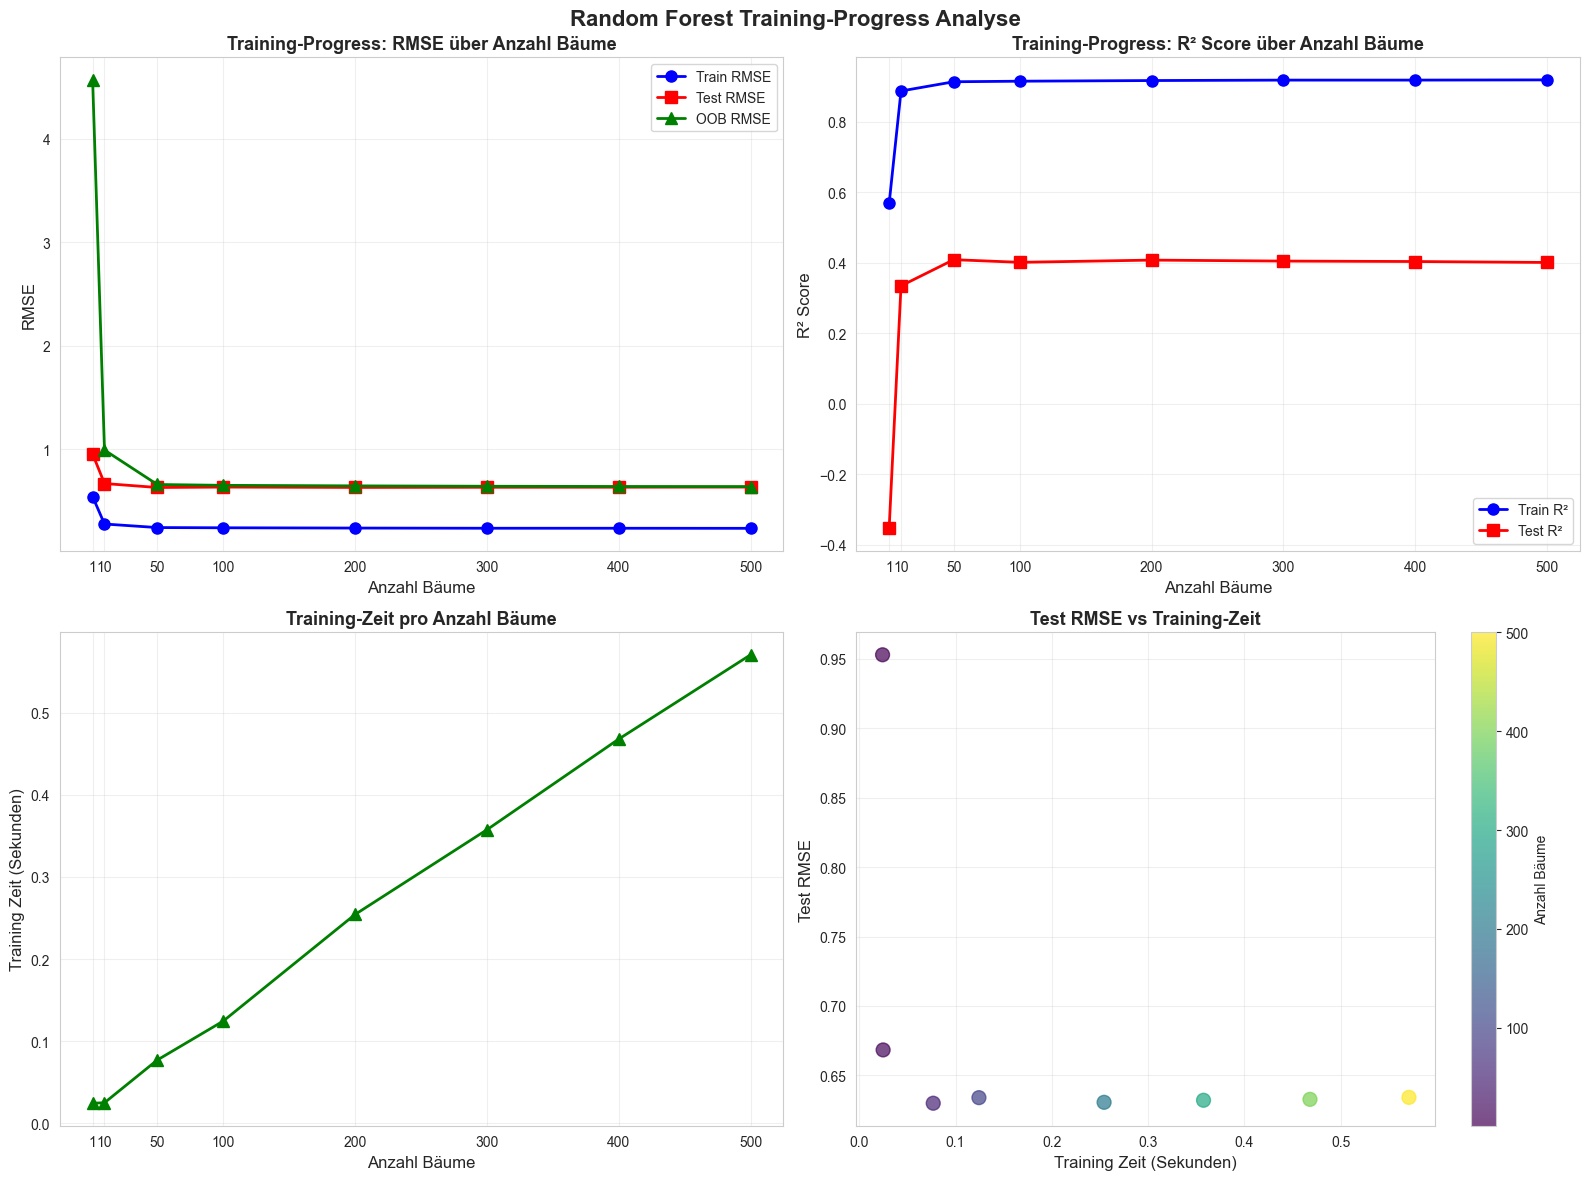

TRAINING-PROGRESS ZUSAMMENFASSUNG

Anzahl Bäume    Train RMSE   Test RMSE    Test R²      Zeit (s)    
--------------------------------------------------------------------------------
1               0.5417       0.9529       -0.3537      0.02        
10              0.2772       0.6683       0.3342       0.02        
50              0.2429       0.6299       0.4085       0.08        
100             0.2407       0.6339       0.4009       0.12        
200             0.2380       0.6306       0.4072       0.25        
300             0.2363       0.6321       0.4045       0.36        
400             0.2362       0.6327       0.4032       0.47        
500             0.2354       0.6341       0.4005       0.57        


In [29]:
# Visualisierung des Training-Progress
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. RMSE über Anzahl Bäume
ax1.plot(n_trees_range, train_errors_progress, 'b-o', label='Train RMSE', linewidth=2, markersize=8)
ax1.plot(n_trees_range, test_errors_progress, 'r-s', label='Test RMSE', linewidth=2, markersize=8)
if any(oob_errors_progress):
    oob_valid = [x for x in oob_errors_progress if x is not None]
    if oob_valid:
        ax1.plot(n_trees_range[:len(oob_valid)], oob_valid, 'g-^', label='OOB RMSE', linewidth=2, markersize=8)
ax1.set_xlabel('Anzahl Bäume', fontsize=12)
ax1.set_ylabel('RMSE', fontsize=12)
ax1.set_title('Training-Progress: RMSE über Anzahl Bäume', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(n_trees_range)

# 2. R² Score über Anzahl Bäume
ax2.plot(n_trees_range, train_r2_progress, 'b-o', label='Train R²', linewidth=2, markersize=8)
ax2.plot(n_trees_range, test_r2_progress, 'r-s', label='Test R²', linewidth=2, markersize=8)
ax2.set_xlabel('Anzahl Bäume', fontsize=12)
ax2.set_ylabel('R² Score', fontsize=12)
ax2.set_title('Training-Progress: R² Score über Anzahl Bäume', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(n_trees_range)

# 3. Training-Zeit pro Anzahl Bäume
ax3.plot(n_trees_range, training_times_progress, 'g-^', linewidth=2, markersize=8, color='green')
ax3.set_xlabel('Anzahl Bäume', fontsize=12)
ax3.set_ylabel('Training Zeit (Sekunden)', fontsize=12)
ax3.set_title('Training-Zeit pro Anzahl Bäume', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(n_trees_range)

# 4. Test RMSE vs Training-Zeit
ax4.scatter(training_times_progress, test_errors_progress, s=100, alpha=0.7, c=n_trees_range, cmap='viridis')
ax4.set_xlabel('Training Zeit (Sekunden)', fontsize=12)
ax4.set_ylabel('Test RMSE', fontsize=12)
ax4.set_title('Test RMSE vs Training-Zeit', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
cbar = plt.colorbar(ax4.collections[0], ax=ax4)
cbar.set_label('Anzahl Bäume', fontsize=10)

plt.suptitle('Random Forest Training-Progress Analyse', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Zusammenfassung des Progress
print("=" * 80)
print("TRAINING-PROGRESS ZUSAMMENFASSUNG")
print("=" * 80)
print(f"\n{'Anzahl Bäume':<15} {'Train RMSE':<12} {'Test RMSE':<12} {'Test R²':<12} {'Zeit (s)':<12}")
print("-" * 80)
for i, n_trees in enumerate(n_trees_range):
    print(f"{n_trees:<15} {train_errors_progress[i]:<12.4f} {test_errors_progress[i]:<12.4f} "
          f"{test_r2_progress[i]:<12.4f} {training_times_progress[i]:<12.2f}")
print("=" * 80)


In [ ]:
# GridSearchCV Training mit Zeitmessung
print("\n" + "=" * 70)
print("GRIDSEARCHCV TRAINING GESTARTET")
print("=" * 70)
start_time = time.time()

grid_search.fit(X_train, y_train)

training_time = time.time() - start_time

# Bestes Modell aus GridSearchCV extrahieren
rf_model = grid_search.best_estimator_

print("\n" + "=" * 70)
print("GRIDSEARCHCV TRAINING ABGESCHLOSSEN")
print("=" * 70)
print(f"Training Zeit: {training_time:.2f} Sekunden ({training_time/60:.2f} Minuten)")
print(f"\nBESTE PARAMETER:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV R² Score: {grid_search.best_score_:.4f}")
print(f"Anzahl getestete Kombinationen: {len(grid_search.cv_results_['params'])}")
print(f"Anzahl trainierte Bäume im besten Modell: {len(rf_model.estimators_)}")
print("=" * 70)



GRIDSEARCHCV TRAINING GESTARTET


NameError: name 'grid_search' is not defined

In [ ]:
# Vorhersagen auf Train- und Test-Set
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

print("Vorhersagen generiert:")
print(f"Train Set Vorhersagen Shape: {y_train_pred.shape}")
print(f"Test Set Vorhersagen Shape: {y_test_pred.shape}")
print(f"\nErste 10 Train Vorhersagen: {y_train_pred[:10]}")
print(f"Erste 10 Test Vorhersagen: {y_test_pred[:10]}")


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


Vorhersagen generiert:
Train Set Vorhersagen Shape: (1087,)
Test Set Vorhersagen Shape: (272,)

Erste 10 Train Vorhersagen: [5.94  5.95  6.486 5.184 5.742 6.108 5.672 5.694 5.342 5.084]
Erste 10 Test Vorhersagen: [5.196 5.98  6.188 6.566 5.114 5.524 6.106 5.248 6.608 5.938]


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    0.0s finished


## 4. Modell-Evaluierung


### Cross-Validation für robuste Evaluierung

Cross-Validation teilt die Trainingsdaten in mehrere Folds auf und testet das Modell auf jedem Fold.
Dies gibt eine robustere Schätzung der Modell-Performance als ein einfacher Train-Test Split.


In [ ]:
# Cross-Validation für robuste Evaluierung
# Teilt Trainingsdaten in CV_FOLDS Teile und testet Modell auf jedem Teil
# Gibt robustere Performance-Schätzung als einfacher Train-Test Split

cv_scores = cross_val_score(
    rf_model,
    X_train,
    y_train,
    cv=CV_FOLDS,
    scoring='r2'
)

print("=" * 70)
print("CROSS-VALIDATION ERGEBNISSE")
print("=" * 70)
print(f"CV R² Scores (pro Fold): {cv_scores}")
print(f"\nStatistik:")
print(f"  Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"  Min CV R²:  {cv_scores.min():.4f}")
print(f"  Max CV R²:  {cv_scores.max():.4f}")
print(f"  Median CV R²: {np.median(cv_scores):.4f}")
print("\nInterpretation:")
print(f"  Die Standardabweichung ({cv_scores.std():.4f}) zeigt die Variabilität")
print(f"  zwischen den Folds. Niedrigere Werte = stabileres Modell.")
print("=" * 70)

# Visualisierung der CV Scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, CV_FOLDS + 1), cv_scores, color='steelblue', alpha=0.7, edgecolor='black')
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', linewidth=2, 
           label=f'Mean ({cv_scores.mean():.4f})')
plt.xlabel('CV Fold', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title(f'{CV_FOLDS}-Fold Cross-Validation Scores', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ylim([max(0, cv_scores.min() - 0.1), min(1, cv_scores.max() + 0.1)])
plt.tight_layout()
plt.show()


In [ ]:
# Metriken berechnen
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("=" * 70)
print("MODELL-EVALUIERUNG")
print("=" * 70)
print("\nTRAIN SET METRIKEN:")
print(f"  Mean Squared Error (MSE):  {train_mse:.4f}")
print(f"  Root Mean Squared Error (RMSE): {train_rmse:.4f}")
print(f"  Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"  R² Score: {train_r2:.4f}")

print("\nTEST SET METRIKEN:")
print(f"  Mean Squared Error (MSE):  {test_mse:.4f}")
print(f"  Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"  Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"  R² Score: {test_r2:.4f}")
print("=" * 70)


MODELL-EVALUIERUNG

TRAIN SET METRIKEN:
  Mean Squared Error (MSE):  0.0554
  Root Mean Squared Error (RMSE): 0.2354
  Mean Absolute Error (MAE): 0.1807
  R² Score: 0.9184

TEST SET METRIKEN:
  Mean Squared Error (MSE):  0.4021
  Root Mean Squared Error (RMSE): 0.6341
  Mean Absolute Error (MAE): 0.4908
  R² Score: 0.4005


In [ ]:
# Feature Importance extrahieren
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("=== FEATURE IMPORTANCE ===\n")
print(feature_importance.to_string(index=False))


=== FEATURE IMPORTANCE ===

             Feature  Importance
             alcohol    0.190892
           sulphates    0.143804
    volatile acidity    0.129756
             density    0.086158
total sulfur dioxide    0.078320
         citric acid    0.074437
           chlorides    0.066819
                  pH    0.063126
       fixed acidity    0.060177
      residual sugar    0.054744
 free sulfur dioxide    0.051768


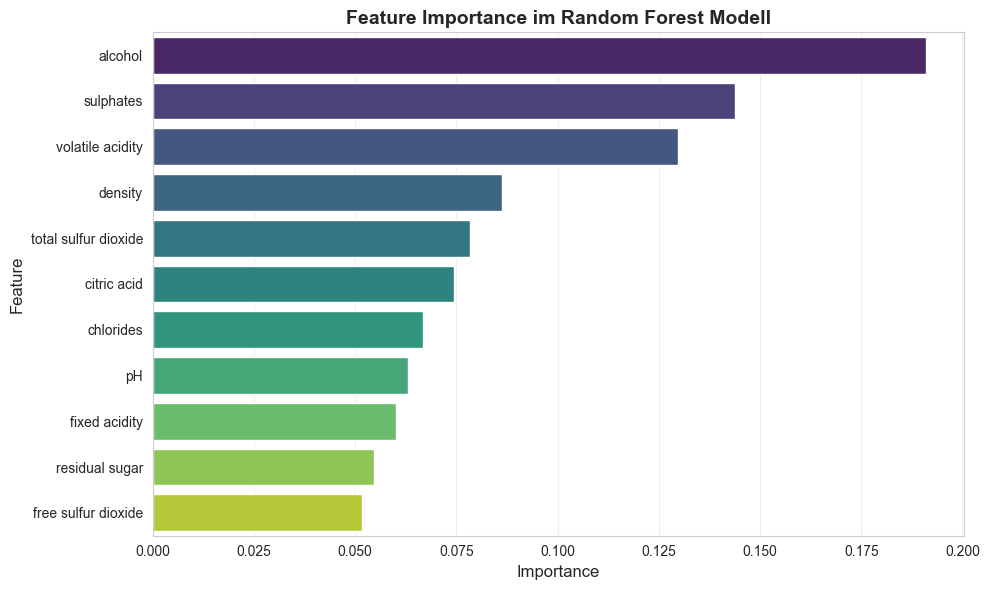

In [ ]:
# Feature Importance Visualisierung
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance im Random Forest Modell', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


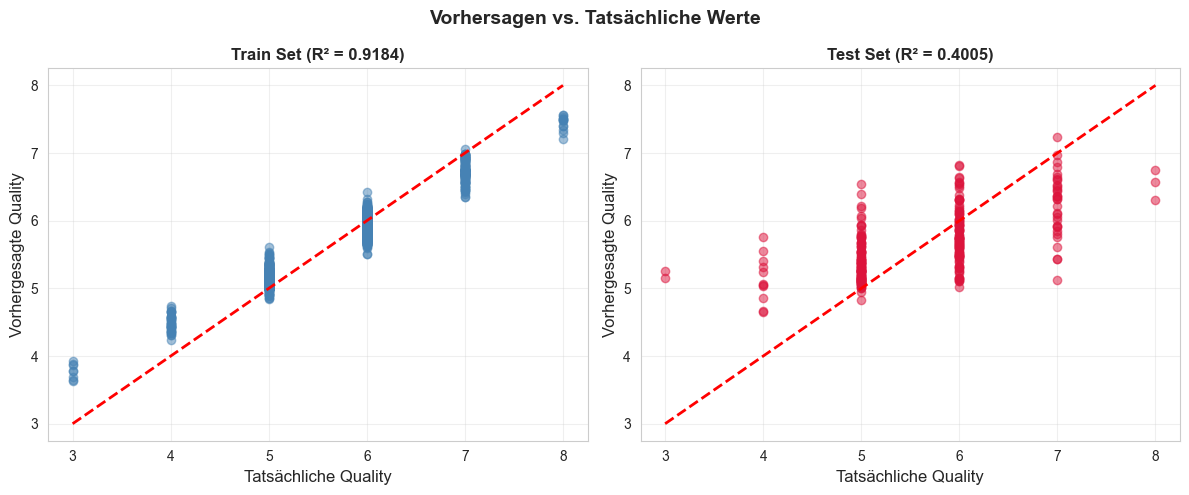

In [ ]:
# Vorhersagen vs. Tatsächliche Werte (Train Set)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5, color='steelblue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Tatsächliche Quality', fontsize=12)
plt.ylabel('Vorhergesagte Quality', fontsize=12)
plt.title(f'Train Set (R² = {train_r2:.4f})', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

# Vorhersagen vs. Tatsächliche Werte (Test Set)
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='crimson')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Tatsächliche Quality', fontsize=12)
plt.ylabel('Vorhergesagte Quality', fontsize=12)
plt.title(f'Test Set (R² = {test_r2:.4f})', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

plt.suptitle('Vorhersagen vs. Tatsächliche Werte', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


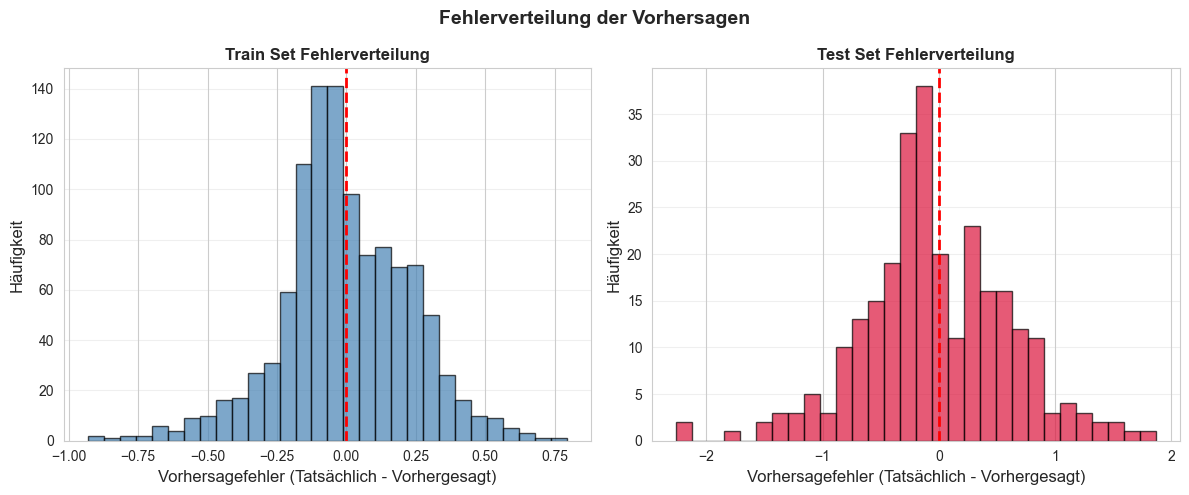

Train Set - Mean Error: -0.0059, Std: 0.2354
Test Set - Mean Error: -0.0325, Std: 0.6345


In [ ]:
# Fehlerverteilung
train_errors = y_train - y_train_pred
test_errors = y_test - y_test_pred

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_errors, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Vorhersagefehler (Tatsächlich - Vorhergesagt)', fontsize=12)
plt.ylabel('Häufigkeit', fontsize=12)
plt.title('Train Set Fehlerverteilung', fontsize=12, fontweight='bold')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(test_errors, bins=30, edgecolor='black', alpha=0.7, color='crimson')
plt.xlabel('Vorhersagefehler (Tatsächlich - Vorhergesagt)', fontsize=12)
plt.ylabel('Häufigkeit', fontsize=12)
plt.title('Test Set Fehlerverteilung', fontsize=12, fontweight='bold')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(axis='y', alpha=0.3)

plt.suptitle('Fehlerverteilung der Vorhersagen', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Train Set - Mean Error: {train_errors.mean():.4f}, Std: {train_errors.std():.4f}")
print(f"Test Set - Mean Error: {test_errors.mean():.4f}, Std: {test_errors.std():.4f}")


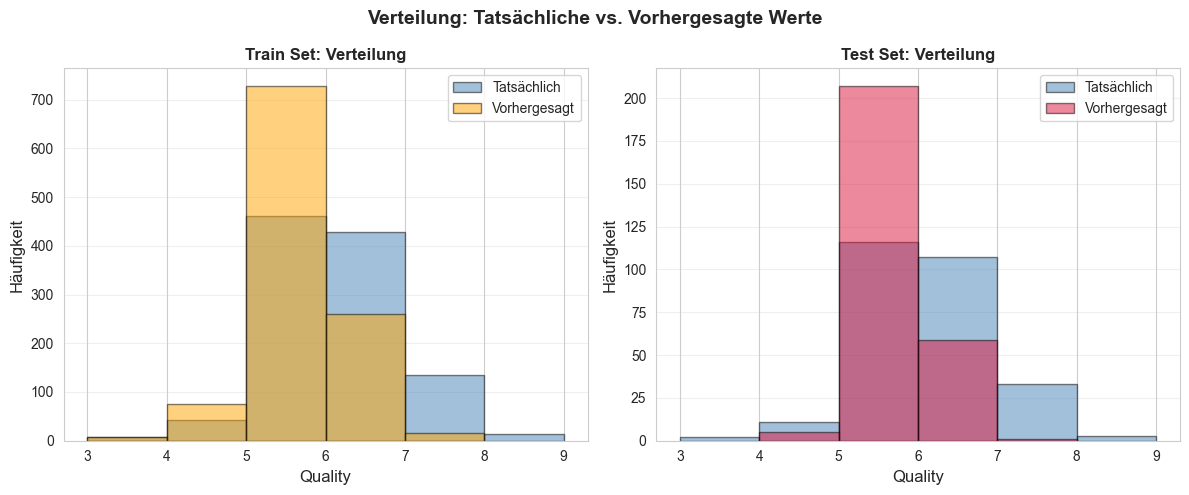

In [ ]:
# Verteilung der Vorhersagen vs. Tatsächliche Werte
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=range(int(y_train.min()), int(y_train.max())+2), 
         alpha=0.5, label='Tatsächlich', color='steelblue', edgecolor='black')
plt.hist(y_train_pred, bins=range(int(y_train_pred.min()), int(y_train_pred.max())+2), 
         alpha=0.5, label='Vorhergesagt', color='orange', edgecolor='black')
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Häufigkeit', fontsize=12)
plt.title('Train Set: Verteilung', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(y_test, bins=range(int(y_test.min()), int(y_test.max())+2), 
         alpha=0.5, label='Tatsächlich', color='steelblue', edgecolor='black')
plt.hist(y_test_pred, bins=range(int(y_test_pred.min()), int(y_test_pred.max())+2), 
         alpha=0.5, label='Vorhergesagt', color='crimson', edgecolor='black')
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Häufigkeit', fontsize=12)
plt.title('Test Set: Verteilung', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.suptitle('Verteilung: Tatsächliche vs. Vorhergesagte Werte', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 6. Finale Fehlerübersicht und Performance-Dashboard


In [ ]:
# ============================================================================
# FINALE FEHLERÜBERSICHT
# ============================================================================

# Berechne alle Metriken nochmal für finale Übersicht
final_train_mse = mean_squared_error(y_train, y_train_pred)
final_train_rmse = np.sqrt(final_train_mse)
final_train_mae = mean_absolute_error(y_train, y_train_pred)
final_train_r2 = r2_score(y_train, y_train_pred)

final_test_mse = mean_squared_error(y_test, y_test_pred)
final_test_rmse = np.sqrt(final_test_mse)
final_test_mae = mean_absolute_error(y_test, y_test_pred)
final_test_r2 = r2_score(y_test, y_test_pred)

# Fehler berechnen
train_errors = y_train - y_train_pred
test_errors = y_test - y_test_pred

print("=" * 80)
print("FINALE FEHLERÜBERSICHT")
print("=" * 80)

print(f"\n{'':<25} {'Train':<12} {'Test':<12} {'Differenz':<12}")
print("-" * 65)
print(f"{'MSE':<25} {final_train_mse:<12.4f} {final_test_mse:<12.4f} {abs(final_train_mse - final_test_mse):<12.4f}")
print(f"{'RMSE':<25} {final_train_rmse:<12.4f} {final_test_rmse:<12.4f} {abs(final_train_rmse - final_test_rmse):<12.4f}")
print(f"{'MAE':<25} {final_train_mae:<12.4f} {final_test_mae:<12.4f} {abs(final_train_mae - final_test_mae):<12.4f}")
print(f"{'R² Score':<25} {final_train_r2:<12.4f} {final_test_r2:<12.4f} {abs(final_train_r2 - final_test_r2):<12.4f}")

# Feature Importance finale Übersicht
top_features = feature_importance.head(5)
print(f"\n{'TOP 5 FEATURES NACH IMPORTANCE':^65}")
print("-" * 65)
for i, (_, row) in enumerate(top_features.iterrows(), 1):
    print(f"{i}. {row['Feature']:<40} {row['Importance']:.4f}")

print("=" * 80)


FINALE FEHLERÜBERSICHT

                          Train        Test         Differenz   
-----------------------------------------------------------------
MSE                       0.0554       0.4021       0.3467      
RMSE                      0.2354       0.6341       0.3987      
MAE                       0.1807       0.4908       0.3100      
R² Score                  0.9184       0.4005       0.5179      

                 TOP 5 FEATURES NACH IMPORTANCE                  
-----------------------------------------------------------------
1. alcohol                                  0.1909
2. sulphates                                0.1438
3. volatile acidity                         0.1298
4. density                                  0.0862
5. total sulfur dioxide                     0.0783


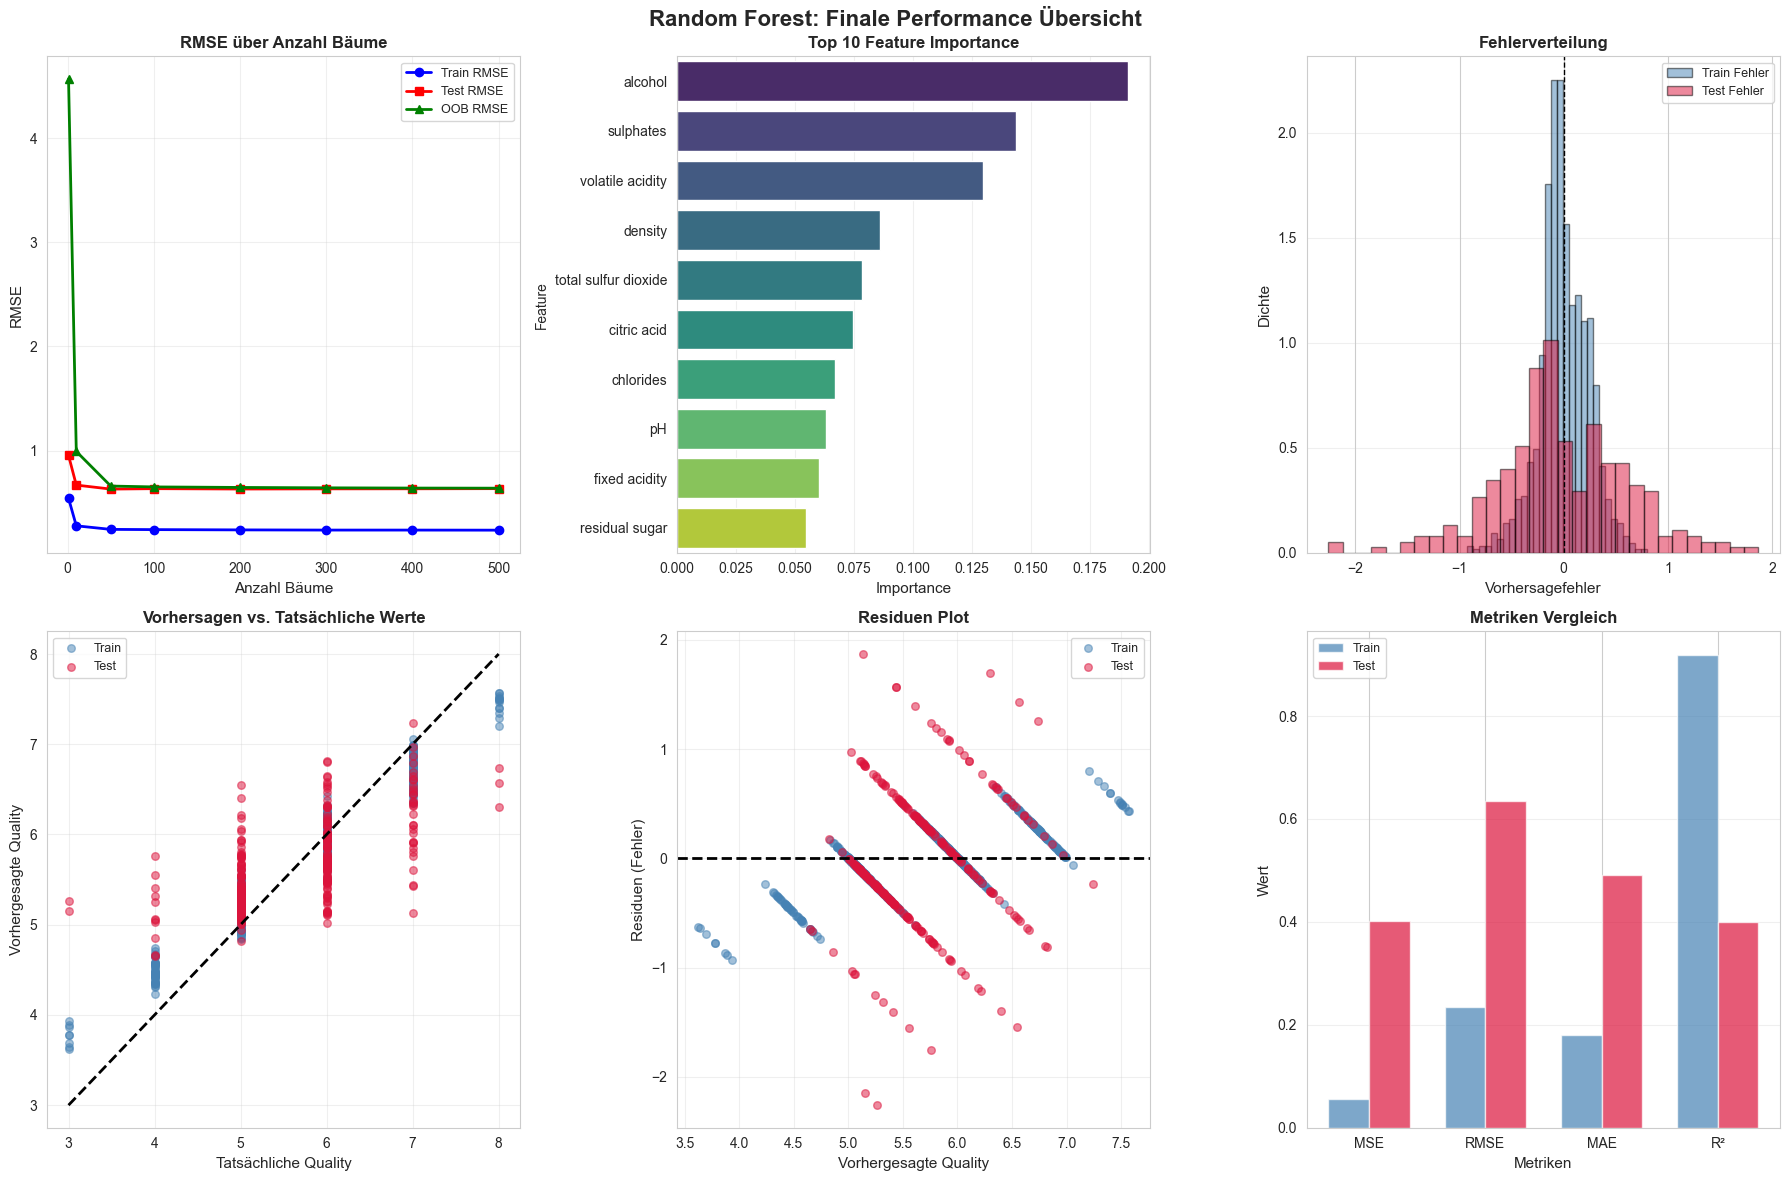

In [ ]:
# Finale Performance Zusammenfassung Dashboard
plt.figure(figsize=(18, 12))

# 1. RMSE über Bäume (Training-Progress)
plt.subplot(2, 3, 1)
plt.plot(n_trees_range, train_errors_progress, 'b-', label='Train RMSE', linewidth=2, marker='o', markersize=6)
plt.plot(n_trees_range, test_errors_progress, 'r-', label='Test RMSE', linewidth=2, marker='s', markersize=6)
if any(oob_errors_progress):
    oob_valid = [x for x in oob_errors_progress if x is not None]
    if oob_valid:
        plt.plot(n_trees_range[:len(oob_valid)], oob_valid, 'g-', label='OOB RMSE', linewidth=2, marker='^', markersize=6)
plt.xlabel('Anzahl Bäume', fontsize=11)
plt.ylabel('RMSE', fontsize=11)
plt.title('RMSE über Anzahl Bäume', fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# 2. Feature Importance
plt.subplot(2, 3, 2)
top_10_features = feature_importance.head(10)
sns.barplot(data=top_10_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importance', fontweight='bold')
plt.xlabel('Importance', fontsize=11)
plt.grid(axis='x', alpha=0.3)

# 3. Fehlerverteilung
plt.subplot(2, 3, 3)
plt.hist(train_errors, bins=30, alpha=0.5, label='Train Fehler', color='steelblue', density=True, edgecolor='black')
plt.hist(test_errors, bins=30, alpha=0.5, label='Test Fehler', color='crimson', density=True, edgecolor='black')
plt.xlabel('Vorhersagefehler', fontsize=11)
plt.ylabel('Dichte', fontsize=11)
plt.title('Fehlerverteilung', fontweight='bold')
plt.legend(fontsize=9)
plt.axvline(x=0, color='k', linestyle='--', linewidth=1)
plt.grid(axis='y', alpha=0.3)

# 4. Vorhersagen vs. Tatsächliche Werte
plt.subplot(2, 3, 4)
plt.scatter(y_train, y_train_pred, alpha=0.5, color='steelblue', s=30, label='Train')
plt.scatter(y_test, y_test_pred, alpha=0.5, color='crimson', s=30, label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', linewidth=2)
plt.xlabel('Tatsächliche Quality', fontsize=11)
plt.ylabel('Vorhergesagte Quality', fontsize=11)
plt.title('Vorhersagen vs. Tatsächliche Werte', fontweight='bold')
plt.legend(fontsize=9)
plt.grid(alpha=0.3)

# 5. Residuen Plot
plt.subplot(2, 3, 5)
plt.scatter(y_train_pred, train_errors, alpha=0.5, color='steelblue', s=30, label='Train')
plt.scatter(y_test_pred, test_errors, alpha=0.5, color='crimson', s=30, label='Test')
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.xlabel('Vorhergesagte Quality', fontsize=11)
plt.ylabel('Residuen (Fehler)', fontsize=11)
plt.title('Residuen Plot', fontweight='bold')
plt.legend(fontsize=9)
plt.grid(alpha=0.3)

# 6. Metriken Vergleich
plt.subplot(2, 3, 6)
metrics = ['MSE', 'RMSE', 'MAE', 'R²']
train_metrics = [final_train_mse, final_train_rmse, final_train_mae, final_train_r2]
test_metrics = [final_test_mse, final_test_rmse, final_test_mae, final_test_r2]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, train_metrics, width, label='Train', color='steelblue', alpha=0.7)
plt.bar(x + width/2, test_metrics, width, label='Test', color='crimson', alpha=0.7)
plt.xlabel('Metriken', fontsize=11)
plt.ylabel('Wert', fontsize=11)
plt.title('Metriken Vergleich', fontweight='bold')
plt.xticks(x, metrics)
plt.legend(fontsize=9)
plt.grid(axis='y', alpha=0.3)

plt.suptitle('Random Forest: Finale Performance Übersicht', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## 7. Modell-Historie speichern


In [ ]:
# ============================================================================
# MODELL-HISTORIE SPEICHERN
# ============================================================================

import os
from datetime import datetime

# Erstelle model_history Ordner falls nicht vorhanden
history_dir = 'model_history'
if not os.path.exists(history_dir):
    os.makedirs(history_dir)
    print(f"Ordner '{history_dir}' wurde erstellt.")

# Generiere Timestamp im Format HH-MM_DD-MM-YY
timestamp = datetime.now().strftime('%H-%M_%d-%m-%y')
filename = f"{timestamp}.csv"
filepath = os.path.join(history_dir, filename)

# Sammle alle wichtigen Metriken und Informationen
model_summary = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_type': 'RandomForestRegressor',
    'dataset': DATA_PATH,
    'n_estimators': N_ESTIMATORS,
    'max_depth': MAX_DEPTH if MAX_DEPTH is not None else 'None',
    'min_samples_split': MIN_SAMPLES_SPLIT,
    'min_samples_leaf': MIN_SAMPLES_LEAF,
    'max_features': MAX_FEATURES,
    'bootstrap': Bootstrap,
    'random_state': RANDOM_STATE,
    'test_size': TEST_SIZE,
    'stratify': STRATIFY,
    'training_time_seconds': training_time,
    'training_time_minutes': training_time / 60,
    'n_train_samples': X_train.shape[0],
    'n_test_samples': X_test.shape[0],
    'n_features': X_train.shape[1],
    'train_mse': final_train_mse,
    'train_rmse': final_train_rmse,
    'train_mae': final_train_mae,
    'train_r2': final_train_r2,
    'test_mse': final_test_mse,
    'test_rmse': final_test_rmse,
    'test_mae': final_test_mae,
    'test_r2': final_test_r2,
    'train_test_rmse_diff': abs(final_train_rmse - final_test_rmse),
    'train_test_r2_diff': abs(final_train_r2 - final_test_r2),
    'oob_score': rf_model.oob_score_ if hasattr(rf_model, 'oob_score_') else None,
}

# Füge Top 5 Features hinzu
for i, (_, row) in enumerate(feature_importance.head(5).iterrows(), 1):
    model_summary[f'top{i}_feature'] = row['Feature']
    model_summary[f'top{i}_importance'] = row['Importance']

# Füge Notes Spalte hinzu (leer für manuelle Eingaben)
model_summary['notes'] = ''

# Erstelle DataFrame und speichere als CSV
summary_df = pd.DataFrame([model_summary])
summary_df.to_csv(filepath, index=False)

print("=" * 80)
print(f"MODELL-ZUSAMMENFASSUNG GESPEICHERT")
print("=" * 80)
print(f"Datei: {filepath}")
print(f"Zeitstempel: {timestamp}")
print(f"\nKurzübersicht:")
print(f"  - Modell: Random Forest ({N_ESTIMATORS} Bäume)")
print(f"  - Train R²: {final_train_r2:.4f}")
print(f"  - Test R²: {final_test_r2:.4f}")
print(f"  - Train RMSE: {final_train_rmse:.4f}")
print(f"  - Test RMSE: {final_test_rmse:.4f}")
print(f"  - Training Zeit: {training_time:.2f}s")
print(f"  - Top Feature: {feature_importance.iloc[0]['Feature']} ({feature_importance.iloc[0]['Importance']:.4f})")
print("=" * 80)


MODELL-ZUSAMMENFASSUNG GESPEICHERT
Datei: model_history\15-29_06-01-26.csv
Zeitstempel: 15-29_06-01-26

Kurzübersicht:
  - Modell: Random Forest (500 Bäume)
  - Train R²: 0.9184
  - Test R²: 0.4005
  - Train RMSE: 0.2354
  - Test RMSE: 0.6341
  - Training Zeit: 0.53s
  - Top Feature: alcohol (0.1909)


## 8. Zusammenfassung

### Modell-Performance:
- **Train R²**: Wird nach Ausführung angezeigt
- **Test R²**: Wird nach Ausführung angezeigt
- **Train RMSE**: Wird nach Ausführung angezeigt
- **Test RMSE**: Wird nach Ausführung angezeigt
- **Training Zeit**: Wird nach Ausführung angezeigt

### Wichtigste Features:
Die Top 3 Features nach Importance werden nach Ausführung angezeigt.

### Vorteile des Random Forest Ansatzes:
1. **Robustheit**: Durch Aggregation von 500 Bäumen wird die Varianz reduziert
2. **Overfitting-Schutz**: Bootstrap-Stichproben und Feature-Subsampling verhindern Overfitting
3. **Feature Importance**: Das Modell zeigt automatisch, welche Features am wichtigsten sind
4. **Keine Skalierung nötig**: Random Forest arbeitet gut mit nicht-skalierten Daten
5. **Training-Progress Tracking**: Visualisierung der Performance während des Trainings

### Nächste Schritte:
- Vergleich mit Neural Network Modell
- Hyperparameter-Tuning (z.B. GridSearchCV)
- Feature Engineering basierend auf Importance-Analyse
- Analyse der Modell-Historie mit `model_history/model_history_analysis.ipynb`


## 5. Ensemble-Aggregation Analyse

### Wie funktioniert die Aggregation der 500 Bäume?

Jeder der 500 Bäume macht eine unabhängige Vorhersage. Das finale Ergebnis ist der **Durchschnitt** aller Vorhersagen. Dies reduziert die Varianz und macht das Modell robuster gegen Overfitting.


In [ ]:
# Beispiel: Vorhersagen einzelner Bäume analysieren
# Wir nehmen ein Beispiel aus dem Test-Set
sample_idx = 0
sample_features = X_test.iloc[[sample_idx]]
true_value = y_test.iloc[sample_idx]

# Vorhersagen aller einzelnen Bäume
individual_predictions = np.array([tree.predict(sample_features)[0] for tree in rf_model.estimators_])
ensemble_prediction = rf_model.predict(sample_features)[0]

print("=" * 70)
print("ENSEMBLE-AGGREGATION BEISPIEL")
print("=" * 70)
print(f"\nBeispiel: Index {sample_idx} aus Test-Set")
print(f"Tatsächlicher Wert: {true_value}")
print(f"\nVorhersagen einzelner Bäume (erste 20):")
print(individual_predictions[:20])
print(f"\nStatistik aller {len(individual_predictions)} Bäume:")
print(f"  Min: {individual_predictions.min():.4f}")
print(f"  Max: {individual_predictions.max():.4f}")
print(f"  Mean: {individual_predictions.mean():.4f}")
print(f"  Median: {np.median(individual_predictions):.4f}")
print(f"  Std: {individual_predictions.std():.4f}")
print(f"\nEnsemble-Vorhersage (Durchschnitt): {ensemble_prediction:.4f}")
print(f"Abweichung vom tatsächlichen Wert: {abs(true_value - ensemble_prediction):.4f}")
print("=" * 70)


ENSEMBLE-AGGREGATION BEISPIEL

Beispiel: Index 0 aus Test-Set
Tatsächlicher Wert: 5

Vorhersagen einzelner Bäume (erste 20):
[6. 5. 5. 5. 5. 6. 5. 5. 5. 6. 5. 6. 4. 5. 5. 5. 5. 6. 5. 5.]

Statistik aller 500 Bäume:
  Min: 3.0000
  Max: 7.0000
  Mean: 5.1960
  Median: 5.0000
  Std: 0.5455

Ensemble-Vorhersage (Durchschnitt): 5.1960
Abweichung vom tatsächlichen Wert: 0.1960


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    0.0s finished


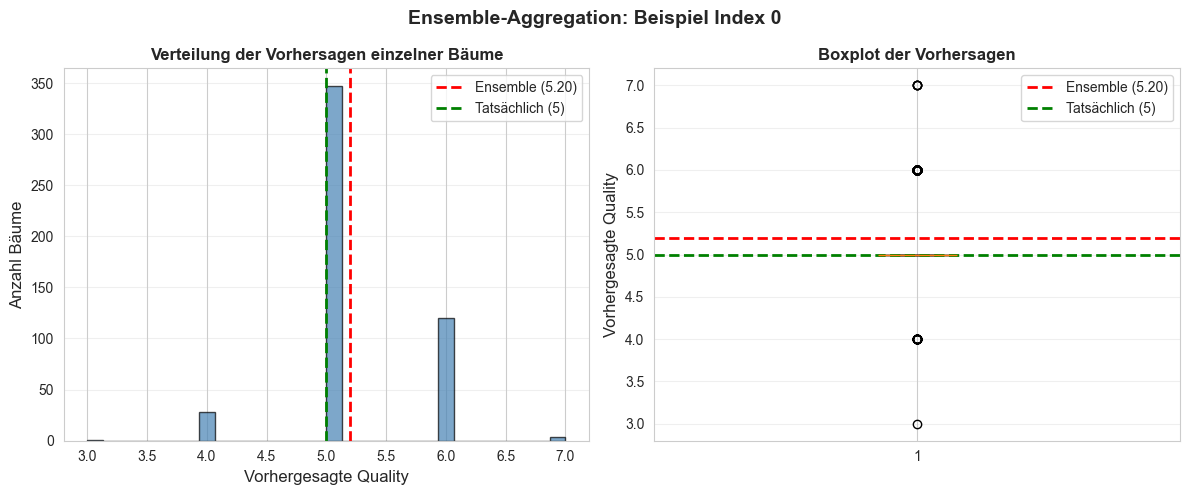

In [ ]:
# Visualisierung der Vorhersagen-Verteilung einzelner Bäume
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(individual_predictions, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.axvline(x=ensemble_prediction, color='r', linestyle='--', linewidth=2, label=f'Ensemble ({ensemble_prediction:.2f})')
plt.axvline(x=true_value, color='g', linestyle='--', linewidth=2, label=f'Tatsächlich ({true_value})')
plt.xlabel('Vorhergesagte Quality', fontsize=12)
plt.ylabel('Anzahl Bäume', fontsize=12)
plt.title('Verteilung der Vorhersagen einzelner Bäume', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(individual_predictions, vert=True)
plt.axhline(y=ensemble_prediction, color='r', linestyle='--', linewidth=2, label=f'Ensemble ({ensemble_prediction:.2f})')
plt.axhline(y=true_value, color='g', linestyle='--', linewidth=2, label=f'Tatsächlich ({true_value})')
plt.ylabel('Vorhergesagte Quality', fontsize=12)
plt.title('Boxplot der Vorhersagen', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.suptitle(f'Ensemble-Aggregation: Beispiel Index {sample_idx}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
# Aktualisiere Parameter mit GridSearchCV besten Werten (falls verwendet)
if USE_GRIDSEARCH:
    model_summary['max_depth'] = grid_search.best_params_['max_depth']
    model_summary['min_samples_split'] = grid_search.best_params_['min_samples_split']
    model_summary['min_samples_leaf'] = grid_search.best_params_['min_samples_leaf']
    model_summary['max_features'] = str(grid_search.best_params_['max_features'])
    model_summary['max_samples'] = str(grid_search.best_params_['max_samples'])
    # Füge GridSearchCV Metriken hinzu
    model_summary['gridsearch_used'] = True
    model_summary['best_cv_score'] = grid_search.best_score_
    if 'cv_scores' in globals():
        model_summary['cv_mean_score'] = cv_scores.mean()
        model_summary['cv_std_score'] = cv_scores.std()
else:
    model_summary['gridsearch_used'] = False
    model_summary['max_samples'] = str(MAX_SAMPLES) if MAX_SAMPLES is not None else 'None'
